## 特征提取

### 双门限法
所谓的端点检测其实就是将语音进行分段，分为轻音，浊音，静音等。主要依据的短时能量以及短时过零率。
短时能量表示为：
$$E_n=\sum\limits_{m=1}^Nx_n^2(m)$$

短时过零率表示为：
$$Z_n=\frac{1}{2}\sum\limits_{m=1}^N|sgn[x_n(m)]-sgn[x_n(m-1)]|$$

在双门限法中，短时能量可以较好地区分浊音，静音，清音的能量比较小，容易误判为静音，而过零率可以区分静音和清音。双门限的方法是设定一高一低两个门限，当达到高门限要求时，并在后面的一段时间内持续超过低门限，表示语音信号的开始。
算法过程：
 - 计算信号的短时能量和短时过零率；
 - 选择一个高门限$T_2$,语音信号的能量包络大部分在门限上，可以进行一次初判。语音起止点位于文献与短时能量包络交点$N_3,N_4$的时间间隔之外。
 - 根据背景噪声，选择一个较低的门限$T_1$,并从初判起点向左，终点向右搜索，分别找到能语音信号与门限值的交点$N_2,N_5$,$N_2N_5$段就是双门限判定的语音段。
 - 以短时过零率为准，从$N_2$向左，$N_5$向右搜索，找到过零率低于的阈值$T_3$的点$N_1$和$N_6$，即为语音段的起止点。

门限的选择是试验获得的。


In [4]:
from utils.soundBase import *
from utils.vad_TwoThr import *

# data, fs = soundBase('C4_1_y.wav').audioread()
fs, data = wavfile.read('./data/C4_1_y.wav') 
data = data / np.max(data)
N = len(data)
wlen = 200
inc = 80
IS = 0.1
overlap = wlen - inc
NIS = int((IS * fs - wlen) // inc + 1)
fn = (N - wlen) // inc + 1

frameTime = FrameTimeC(fn, wlen, inc, fs)
time = [i / fs for i in range(N)]

voiceseg, vsl, SF, NF, amp, zcr = vad_TwoThr(data, wlen, inc, NIS)

plt.subplot(3, 1, 1)
plt.plot(time, data)

plt.subplot(3, 1, 2)
plt.plot(frameTime, amp)

plt.subplot(3, 1, 3)
plt.plot(frameTime, zcr)

for i in range(vsl):
    plt.subplot(3, 1, 1)
    plt.plot(frameTime[voiceseg[i]['start']], 1, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 1, 'or')

    plt.subplot(3, 1, 2)
    plt.plot(frameTime[voiceseg[i]['start']], 1, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 1, 'or')

    plt.subplot(3, 1, 3)
    plt.plot(frameTime[voiceseg[i]['start']], 1, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 1, 'or')

plt.savefig('images/TwoThr.png')
plt.close()



![twothre](images/TwoThr.png)

### 相关法
短时自相关：
$$R_n(k)=\sum\limits_{m=1}^{N-k}x_n(m)x_n(m+k)，其中(0\leqslant k \leqslant K)$$

$K$是最大延迟点数。对于浊音语音可以用于自相关函数求出语音波形序列的基音周期。为了避免检测过程的绝对能量带来的影响，把自相关函数进行归一化处理：
$$R_n(k)=R_n(k)/R_n(0),(0\leqslant k \leqslant K)$$

只有噪声的信号求自相关得到的序列是比较小的序列，如果是含噪语音信号，会有一个较大的值，可以通过这个获取语音起点。设置两个阈值$T_1,T_2$,当相关函数最大值大于$T_2$判定为语音，当相关函数最大值大于或小于$T_1$时，判断为语音信号的端点。
 

In [1]:
from utils.common import enframe
from utils.timefeature import *


def vad_forw(dst1, T1, T2):
    fn = len(dst1)
    maxsilence = 8
    minlen = 5
    status = 0
    count = np.zeros(fn)
    silence = np.zeros(fn)
    xn = 0
    x1 = np.zeros(fn)
    x2 = np.zeros(fn)
    for n in range(1, fn):
        if status == 0 or status == 1:
            if dst1[n] > T2:
                x1[xn] = max(1, n - count[xn] - 1)
                status = 2
                silence[xn] = 0
                count[xn] += 1
            elif dst1[n] > T1:
                status = 1
                count[xn] += 1
            else:
                status = 0
                count[xn] = 0
                x1[xn] = 0
                x2[xn] = 0
        if status == 2:
            if dst1[n] > T1:
                count[xn] += 1
            else:
                silence[xn] += 1
                if silence[xn] < maxsilence:
                    count[xn] += 1
                elif count[xn] < minlen:
                    status = 0
                    silence[xn] = 0
                    count[xn] = 0
                else:
                    status = 3
                    x2[xn] = x1[xn] + count[xn]
        if status == 3:
            status = 0
            xn += 1
            count[xn] = 0
            silence[xn] = 0
            x1[xn] = 0
            x2[xn] = 0
    el = len(x1[:xn])
    if x1[el - 1] == 0:
        el -= 1
    if x2[el - 1] == 0:
        print('Error: Not find endding point!\n')
        x2[el] = fn
    SF = np.zeros(fn)
    NF = np.ones(fn)
    for i in range(el):
        SF[int(x1[i]):int(x2[i])] = 1
        NF[int(x1[i]):int(x2[i])] = 0
    voiceseg = findSegment(np.where(SF == 1)[0])
    vsl = len(voiceseg.keys())
    return voiceseg, vsl, SF, NF


def findSegment(express):
    """
    分割成語音段
    :param express:
    :return:
    """
    if express[0] == 0:
        voiceIndex = np.where(express)
    else:
        voiceIndex = express
    d_voice = np.where(np.diff(voiceIndex) > 1)[0]
    voiceseg = {}
    if len(d_voice) > 0:
        for i in range(len(d_voice) + 1):
            seg = {}
            if i == 0:
                st = voiceIndex[0]
                en = voiceIndex[d_voice[i]]
            elif i == len(d_voice):
                st = voiceIndex[d_voice[i - 1] + 1]
                en = voiceIndex[-1]
            else:
                st = voiceIndex[d_voice[i - 1] + 1]
                en = voiceIndex[d_voice[i]]
            seg['start'] = st
            seg['end'] = en
            seg['duration'] = en - st + 1
            voiceseg[i] = seg
    return voiceseg


def vad_corr(y, wnd, inc, NIS, th1, th2):
    x = enframe(y, wnd, inc)
    Ru = STAc(x.T)[0]
    Rum = Ru / np.max(Ru)
    thredth = np.max(Rum[:NIS])
    T1 = th1 * thredth
    T2 = th2 * thredth
    voiceseg, vsl, SF, NF = vad_forw(Rum, T1, T2)
    return voiceseg, vsl, SF, NF, Rum


In [2]:
from utils.soundBase import *
from utils.end_detection import *

# data, fs = soundBase('C4_1_y.wav').audioread()
fs, data = wavfile.read('./data/C4_1_y.wav') 
data = data - np.mean(data)
data = data / np.max(data)
IS = 0.25
wlen = 200
inc = 80
N = len(data)
time = [i / fs for i in range(N)]
wnd = np.hamming(wlen)
NIS = int((IS * fs - wlen) // inc + 1)
thr1 = 1.1
thr2 = 1.3
voiceseg, vsl, SF, NF, Rum = vad_corr(data, wnd, inc, NIS, thr1, thr2)
fn = len(SF)
frameTime = FrameTimeC(fn, wlen, inc, fs)

plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.subplot(2, 1, 2)
plt.plot(frameTime, Rum)

for i in range(vsl):
    plt.subplot(2, 1, 1)
    plt.plot(frameTime[voiceseg[i]['start']], 0, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 0, 'or')
    plt.legend(['signal', 'start', 'end'])

    plt.subplot(2, 1, 2)
    plt.plot(frameTime[voiceseg[i]['start']], 0, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 0, 'or')
    plt.legend(['xcorr', 'start', 'end'])

plt.savefig('images/corr.png')
plt.close()


![corr](images/corr.png)

### 谱熵法
熵是表示信号的有序程度，语音信号的熵与噪声信号的上有较大差异。谱熵端点检测是通过检测谱的平坦程度，检测语音端点。在相同的语音信号，当信噪比降低时，谱熵值的形状大体保持不变。

假设语音信号为$x(i)$，加窗分帧后得到第$n$帧为$x_n(m)$,其FFT表示为：$X_n(k)$,k表示第k条谱线。语音帧在频域的短时能量为：
$$E_n=\sum_{k=0}^{N/2}X_n(k)X_n^*(k)$$

其中N为FFT长度，只取正频率部分。第$k$谱线的能量谱为$Y_n(k)=X_n(k)X_n^*(k)$,每个频率分量的归一化谱概率密度函数为：
$$p_n(k)=\frac{Y_n(k)}{\sum_{k=0}^{N/2}Y_n(l)}=\frac{Y_n(k)}{E_n}$$

该帧短时谱熵定义为：
$$H_n=-\sum_{l=0}^{N/2}p_n(k)\lg p_n(k)$$

基于谱熵的端点检测算法过程：
 - 对语音信号分帧，加窗，取FFT的点数。
 - 计算出每帧的谱的能量。
 - 计算每帧每个样本的概率密度函数。
 - 计算每帧的谱熵值。
 - 设置判决门限。
 - 更加各帧的谱熵值进行端点检测。

计算每帧的谱熵值用：
$$H(i)=\sum_{i=0}^{N/2-1}P(n,i)*\lg [1/P(n,i)]$$

$H(i)$为第i帧的谱熵，$H(i)$计算的谱的能量变化，而不是谱的能量。可以在不同噪声环境下有一定的稳健性。


In [4]:
from utils.common import enframe
from utils.timefeature import *


def vad_revr(dst1, T1, T2):
    """
    端点检测反向比较函数
    :param dst1:
    :param T1:
    :param T2:
    :return:
    """
    fn = len(dst1)
    maxsilence = 8
    minlen = 5
    status = 0
    count = np.zeros(fn)
    silence = np.zeros(fn)
    xn = 0
    x1 = np.zeros(fn)
    x2 = np.zeros(fn)
    for n in range(1, fn):
        if status == 0 or status == 1:
            if dst1[n] < T2:
                x1[xn] = max(1, n - count[xn] - 1)
                status = 2
                silence[xn] = 0
                count[xn] += 1
            elif dst1[n] < T1:
                status = 1
                count[xn] += 1
            else:
                status = 0
                count[xn] = 0
                x1[xn] = 0
                x2[xn] = 0
        if status == 2:
            if dst1[n] < T1:
                count[xn] += 1
            else:
                silence[xn] += 1
                if silence[xn] < maxsilence:
                    count[xn] += 1
                elif count[xn] < minlen:
                    status = 0
                    silence[xn] = 0
                    count[xn] = 0
                else:
                    status = 3
                    x2[xn] = x1[xn] + count[xn]
        if status == 3:
            status = 0
            xn += 1
            count[xn] = 0
            silence[xn] = 0
            x1[xn] = 0
            x2[xn] = 0
    el = len(x1[:xn])
    if x1[el - 1] == 0:
        el -= 1
    if x2[el - 1] == 0:
        print('Error: Not find endding point!\n')
        x2[el] = fn
    SF = np.zeros(fn)
    NF = np.ones(fn)
    for i in range(el):
        SF[int(x1[i]):int(x2[i])] = 1
        NF[int(x1[i]):int(x2[i])] = 0
    voiceseg = findSegment(np.where(SF == 1)[0])
    vsl = len(voiceseg.keys())
    return voiceseg, vsl, SF, NF


def findSegment(express):
    """
    分割成語音段
    :param express:
    :return:
    """
    if express[0] == 0:
        voiceIndex = np.where(express)
    else:
        voiceIndex = express
    d_voice = np.where(np.diff(voiceIndex) > 1)[0]
    voiceseg = {}
    if len(d_voice) > 0:
        for i in range(len(d_voice) + 1):
            seg = {}
            if i == 0:
                st = voiceIndex[0]
                en = voiceIndex[d_voice[i]]
            elif i == len(d_voice):
                st = voiceIndex[d_voice[i - 1] + 1]
                en = voiceIndex[-1]
            else:
                st = voiceIndex[d_voice[i - 1] + 1]
                en = voiceIndex[d_voice[i]]
            seg['start'] = st
            seg['end'] = en
            seg['duration'] = en - st + 1
            voiceseg[i] = seg
    return voiceseg


def vad_specEN(data, wnd, inc, NIS, thr1, thr2, fs):
    import matplotlib.pyplot as plt
    from scipy.signal import medfilt
    x = enframe(data, wnd, inc)
    X = np.abs(np.fft.fft(x, axis=1))
    if len(wnd) == 1:
        wlen = wnd
    else:
        wlen = len(wnd)
    df = fs / wlen
    fx1 = int(250 // df + 1)  # 250Hz位置
    fx2 = int(3500 // df + 1)  # 500Hz位置
    km = wlen // 8
    K = 0.5
    E = np.zeros((X.shape[0], wlen // 2))
    E[:, fx1 + 1:fx2 - 1] = X[:, fx1 + 1:fx2 - 1]
    E = np.multiply(E, E)
    Esum = np.sum(E, axis=1, keepdims=True)
    P1 = np.divide(E, Esum)
    E = np.where(P1 >= 0.9, 0, E)
    Eb0 = E[:, 0::4]
    Eb1 = E[:, 1::4]
    Eb2 = E[:, 2::4]
    Eb3 = E[:, 3::4]
    Eb = Eb0 + Eb1 + Eb2 + Eb3
    prob = np.divide(Eb + K, np.sum(Eb + K, axis=1, keepdims=True))
    Hb = -np.sum(np.multiply(prob, np.log10(prob + 1e-10)), axis=1)
    for i in range(10):
        Hb = medfilt(Hb, 5)
    Me = np.mean(Hb)
    eth = np.mean(Hb[:NIS])
    Det = eth - Me
    T1 = thr1 * Det + Me
    T2 = thr2 * Det + Me
    voiceseg, vsl, SF, NF = vad_revr(Hb, T1, T2)
    return voiceseg, vsl, SF, NF, Hb


In [5]:
from utils.soundBase import *
from utils.end_detection import *

# data, fs = soundBase('C4_1_y.wav').audioread()
fs, data = wavfile.read('./data/C4_1_y.wav') 
data = data - np.mean(data)
data = data - np.max(data)
IS = 0.25
wlen = 200
inc = 80
N = len(data)
time = [i / fs for i in range(N)]
wnd = np.hamming(wlen)
overlap = wlen - inc
NIS = int((IS * fs - wlen) // inc + 1)
thr1 = 0.99
thr2 = 0.96
voiceseg, vsl, SF, NF, Enm = vad_specEN(data, wnd, inc, NIS, thr1, thr2, fs)

fn = len(SF)
frameTime = FrameTimeC(fn, wlen, inc, fs)

plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.subplot(2, 1, 2)
plt.plot(frameTime, Enm)

for i in range(vsl):
    plt.subplot(2, 1, 1)
    plt.plot(frameTime[voiceseg[i]['start']], 0, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 0, 'or')
    plt.legend(['signal', 'start', 'end'])

    plt.subplot(2, 1, 2)
    plt.plot(frameTime[voiceseg[i]['start']], 0, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 0, 'or')
    plt.legend(['熵谱', 'start', 'end'])

plt.savefig('images/En.png')
plt.close()


![EN](images/En.png)

### 比例法

在噪声情况下，信号的短时能量与过零率可能发生一定变化，甚至影响端点检测。用能量值除以过零率的值，可以突出说话区间，更容易检测过语音端点。将短时能量更新为：
$$LE_n=\lg(1+E_n/a)$$

其中$a$为常数，适当取值可以区分噪声和清音。过零率的定义首先要对信号进行限幅处理：
$$\hat x(m)=\left \{\begin{array}{ll}
    x_n(m)&,|x_n(m)>\sigma|\\
    0&,|x_n(m)<\sigma|
\end{array}\right.$$

**能零比**可以表示为：
$$EZR_n=LE_n/(ZCR_n+b)$$

$b$是一个较小的常数，为了防止除0的错误发生。

**能熵比**：
$$EEF_n=\sqrt{1+|LE_n/H_n|}$$

In [6]:
def vad_pro(data, wnd, inc, NIS, thr1, thr2, mode):
    from scipy.signal import medfilt
    x = enframe(data, wnd, inc)
    if len(wnd) == 1:
        wlen = wnd
    else:
        wlen = len(wnd)
    if mode == 1:
        a = 2
        b = 1
        LEn = np.log10(1 + np.sum(np.multiply(x, x) / a, axis=1))
        EZRn = LEn / (STZcr(data, wlen, inc) + b)
        for i in range(10):
            EZRn = medfilt(EZRn, 5)
        dth = np.mean(EZRn[:NIS])
        T1 = thr1 * dth
        T2 = thr2 * dth
        Epara = EZRn
    elif mode == 2:
        a = 2
        X = np.abs(np.fft.fft(x, axis=1))
        X = X[:, :wlen // 2]
        Esum = np.log10(1 + np.sum(np.multiply(X, X) / a, axis=1))
        prob = X / np.sum(X, axis=1, keepdims=True)
        Hn = -np.sum(np.multiply(prob, np.log10(prob + 1e-10)), axis=1)
        Ef = np.sqrt(1 + np.abs(Esum / Hn))
        for i in range(10):
            Ef = medfilt(Ef, 5)
        Me = np.max(Ef)
        eth = np.mean(Ef[NIS])
        Det = Me - eth
        T1 = thr1 * Det + eth
        T2 = thr2 * Det + eth
        Epara = Ef
    voiceseg, vsl, SF, NF = vad_forw(Epara, T1, T2)
    return voiceseg, vsl, SF, NF, Epara

In [8]:
from utils.soundBase import *
from utils.end_detection import *

# data, fs = soundBase('C4_1_y.wav').audioread()
fs, data = wavfile.read('./data/C4_1_y.wav') 
data = data - np.mean(data)
data = data - np.max(data)
IS = 0.25
wlen = 200
inc = 80
N = len(data)
time = [i / fs for i in range(N)]
wnd = np.hamming(wlen)
overlap = wlen - inc
NIS = int((IS * fs - wlen) // inc + 1)

mode = 2
if mode == 1:
    thr1 = 3
    thr2 = 4
    tlabel = '能零比'
elif mode == 2:
    thr1 = 0.05
    thr2 = 0.1
    tlabel = '能熵比'
voiceseg, vsl, SF, NF, Epara = vad_pro(data, wnd, inc, NIS, thr1, thr2, mode)

fn = len(SF)
frameTime = FrameTimeC(fn, wlen, inc, fs)

plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.subplot(2, 1, 2)
plt.plot(frameTime, Epara)

for i in range(vsl):
    plt.subplot(2, 1, 1)
    plt.plot(frameTime[voiceseg[i]['start']], 0, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 0, 'or')
    plt.legend(['signal', 'start', 'end'])

    plt.subplot(2, 1, 2)
    plt.plot(frameTime[voiceseg[i]['start']], 0, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 0, 'or')
    plt.legend([tlabel, 'start', 'end'])

plt.savefig('images/{}.png'.format(tlabel))
plt.close()


![ss](images/能熵比.png)

![sss](images/能零比.png)

### 对数频率距离
对于语音信号取FFT有：
$$X_i(k)=\sum_{m=0}^{N-1}x_i(m)\exp{j\frac{2\pi mk}{N}},k=0,1,...,N-1$$

对$X_i(k)$取对数有：
$$\hat X_i(k)=20\lg |X_i(k)|$$

两个信号$x_1(n)$和$x_2(n)$的对数频谱距离定义为：
$$d_{spec}(i)=\frac{1}{N_2}\sum_{k=0}^{N_2-1}[\hat X_i^1(k)-\hat X_i^2(k)]^2$$

其中$N_2$表示只取正频率部分，即$N_2=N/2+1$。可以预先计算一些噪声的频率频谱，然后用待检测信号段与平均噪声做距离运算，可以得出是不是噪声，从而进行判断。


In [9]:
def vad_LogSpec(signal, noise, NoiseCounter=0, NoiseMargin=3, Hangover=8):
    """
    对数频率距离检测语音端点
    :param signal:
    :param noise:
    :param NoiseCounter:
    :param NoiseMargin:
    :param Hangover:
    :return:
    """
    SpectralDist = 20 * (np.log10(signal) - np.log10(noise))
    SpectralDist = np.where(SpectralDist < 0, 0, SpectralDist)
    Dist = np.mean(SpectralDist)
    if Dist < NoiseMargin:
        NoiseFlag = 1
        NoiseCounter += 1
    else:
        NoiseFlag = 0
        NoiseCounter = 0
    if NoiseCounter > Hangover:
        SpeechFlag = 0
    else:
        SpeechFlag = 1
    return NoiseFlag, SpeechFlag, NoiseCounter, Dist

In [11]:
from utils.soundBase import *
from utils.end_detection import *


def awgn(x, snr):
    snr = 10 ** (snr / 10.0)
    xpower = np.sum(x ** 2) / len(x)
    npower = xpower / snr
    return np.random.randn(len(x)) * np.sqrt(npower) + x


# data, fs = soundBase('C4_1_y.wav').audioread()
fs, data = wavfile.read('./data/C4_1_y.wav') 
data = data - np.mean(data)
data = data /np.max(data)
IS = 0.25
wlen = 200
inc = 80
SNR = 10
N = len(data)
time = [i / fs for i in range(N)]
wnd = np.hamming(wlen)
overlap = wlen - inc
NIS = int((IS * fs - wlen) // inc + 1)
signal = awgn(data, SNR)

y = enframe(signal, wnd, inc)
frameTime = FrameTimeC(y.shape[0], wlen, inc, fs)

Y = np.abs(np.fft.fft(y, axis=1))
Y = Y[:, :wlen // 2]
N = np.mean(Y[:NIS, :], axis=0)
NoiseCounter = 0
SF = np.zeros(y.shape[0])
NF = np.zeros(y.shape[0])
D = np.zeros(y.shape[0])
# 前导段设置NF=1,SF=0
SF[:NIS] = 0
NF[:NIS] = 1
for i in range(NIS, y.shape[0]):
    NoiseFlag, SpeechFlag, NoiseCounter, Dist = vad_LogSpec(Y[i, :], N, NoiseCounter, 2.5, 8)
    SF[i] = SpeechFlag
    NF[i] = NoiseFlag
    D[i] = Dist
sindex = np.where(SF == 1)
voiceseg = findSegment(np.where(SF == 1)[0])
vosl = len(voiceseg)

plt.subplot(3, 1, 1)
plt.plot(time, data)
plt.subplot(3, 1, 2)
plt.plot(time, signal)
plt.subplot(3, 1, 3)
plt.plot(frameTime, D)

for i in range(vosl):
    plt.subplot(3, 1, 1)
    plt.plot(frameTime[voiceseg[i]['start']], 0, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 0, 'or')
    plt.legend(['signal', 'start', 'end'])

    plt.subplot(3, 1, 2)
    plt.plot(frameTime[voiceseg[i]['start']], 0, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 0, 'or')
    plt.legend(['noised', 'start', 'end'])

    plt.subplot(3, 1, 3)
    plt.plot(frameTime[voiceseg[i]['start']], 1, '.k')
    plt.plot(frameTime[voiceseg[i]['end']], 1, 'or')
    plt.legend(['对数频率距离', 'start', 'end'])

plt.savefig('images/对数频率距离.png')
plt.close()



![对数频率距离](images/对数频率距离.png)

## 基音周期检测

人在发声时候，根据声带是否振动可以将语音信号分为清音和浊音。
 - 浊音：有声语音，携带语言中大部分能量，在时域上有明显的周期性
 - 清音：类似于白噪声，没明显周期性

在发浊音时候，声门使声带产生张弛震荡式振动，产生准周期激励冲激串。这种声带振动的频率被称为基音频率，相应的周期就是基音周期。基音频率在很大程度上反应了个人的特征。比如，男性的基音频率范围在70-200Hz范围内，女性和小孩的基音频率在200-450Hz之间。

基音周期的估计就是基音检测，基音检测的最终目的是为了找出和声带振动频率完全一致或者尽可能相同的轨迹曲线。目前基音检测可大致分为：非基于时间检测和基于事件检测（事件是指声门闭合）。

非基于事件检测方法有：自相关函数法，平均幅值差函数法，倒谱法。计算量小，但是准确率不一定高。基于事件检测方法是指通过声门闭合的时刻开对基音周期进行估计，而不需要对语音信号进行短时平稳假设，主要有小波变换，Hilbert-Huang变换。由于这是时频域的处理方式，所以在时频域上都有较好的局部特性，检测精度高，但是计算量巨大。

### 基音检测预处理
由于语音信号的头部与尾部不具有声带震荡的周期性。为了提高检测准确率，基音检测通常要进行端点检测，但是基音检测的端点检测更加严格，这里采用能熵比的方式：
$$EEF_n=\sqrt{1+|LE_n/H_n|}$$

但是只用一个$T_1$门限做判断，判断能熵比是不是大于$T_1$，认为大于$T_1$的部分是有效段的候选值。再判断长度是不是大于最小长度$L_{min}$,一般认为$L_{min}=10$。

为了减少共振峰的干扰，选择60-500Hz的预处理滤波器。由于语音信号对相位不敏感，可以考虑选择计算量小的椭圆IIR滤波器。

### 倒谱法
由于语音信号$x(i)$是由声门脉冲激励$u(i)$经声道响应$v(i)$滤波得到：
$$x(i)=u(i)*v(i)$$

并计算倒谱$\hat x(i),\hat u(i),\hat v(i)$有：
$$\hat x(i)=\hat u(i)+\hat v(i)$$

由于倒谱的$\hat u(i),\hat v(i)$是相对分离的，包含基音信息的脉冲倒谱可与声道响应倒谱分离，所以可以从倒谱域分离$\hat u(i)$后恢复出$u(i)$，从而求出基音周期。计算出倒谱后，在倒谱域中找到$P_{min},P_{max}$中的倒谱函数的最大值，对于的样本点数就是当前帧语音信号的基音周期$T_0(n)$,基音频率为$F_0(n)=f_s/T_0(n)$.

### 短时自相关法

先求出自相关函数，如果延迟量等于基音周期，那么两个信号具有最大类似性，或直接找出短时自相关函数两个最大值之间的距离作为基音周期的估计。

### 线性预测法
信号与线性预测之间的差为线性预测误差：
$$e(n)=s(n)-\hat s(n)=s(n)-\sum\limits_{i=1}^pa_is(n-i)$$

由于线性预测误差已经去除了共振峰的影响，其倒谱能领能把声道的影响减到最小，所以通过线性预测误差$e(m)$通过倒谱运算可可以提取出基音周期。


In [1]:
from utils.common import enframe
from utils.timefeature import *
from utils.end_detection import findSegment


def pitch_vad(x, wnd, inc, T1, miniL=10):
    """
    使用能熵比检测基音，实际上就是语音分段
    :param x:
    :param wnd:
    :param inc:
    :param T1:
    :param miniL:
    :return:
    """
    y = enframe(x, wnd, inc)
    fn = y.shape[0]
    if isinstance(wnd, int):
        wlen = wnd
    else:
        wlen = len(wnd)

    Sp = np.abs(np.fft.fft(y, axis=1))
    Sp = Sp[:, :wlen // 2 + 1]
    Esum = np.sum(np.multiply(Sp, Sp), axis=1)
    prob = Sp / np.sum(Sp, axis=1, keepdims=True)
    H = -np.sum(np.multiply(prob, np.log10(prob + 1e-16)), axis=1)
    H = np.where(H < 0.1, np.max(H), H)
    Ef = np.sqrt(1 + np.abs(Esum / H))
    Ef = Ef / np.max(Ef)

    zseg = findSegment(np.where(Ef > T1)[0])
    zsl = len(zseg.keys())
    print(1)
    SF = np.zeros(fn)
    for k in range(zsl):
        if zseg[k]['duration'] < miniL:
            zseg = zseg.pop(k)
        else:
            SF[zseg[k]['start']:zseg[k]['end']] = 1
    return zseg, len(zseg.keys()), SF, Ef


def pitch_Ceps(x, wnd, inc, T1, fs, miniL=10):
    """
    倒谱法基音周期检测函数
    :param x:
    :param wnd:
    :param inc:
    :param T1:
    :param fs:
    :param miniL:
    :return:
    """
    y = enframe(x, wnd, inc)
    fn = y.shape[0]
    if isinstance(wnd, int):
        wlen = wnd
    else:
        wlen = len(wnd)
    voiceseg, vsl, SF, Ef = pitch_vad(x, wnd, inc, T1, miniL)
    lmin = fs // 500  # 基音周期的最小值
    lmax = fs // 60  # 基音周期的最大值
    period = np.zeros(fn)
    y1 = y[np.where(SF == 1)[0], :]
    y1 = np.multiply(y1, np.hamming(wlen))
    xx = np.fft.fft(y1, axis=1)
    b = np.fft.ifft(2 * np.log(np.abs(xx) + 1e-10))
    Lc = np.argmax(b[:, lmin:lmax], axis=1) + lmin - 1
    period[np.where(SF == 1)[0]] = Lc
    return voiceseg, vsl, SF, Ef, period


def pitch_Corr(x, wnd, inc, T1, fs, miniL=10):
    """
    自相关法基音周期检测函数
    :param x: 
    :param wnd: 
    :param inc: 
    :param T1: 
    :param fs: 
    :param miniL: 
    :return: 
    """
    y = enframe(x, wnd, inc)
    fn = y.shape[0]
    if isinstance(wnd, int):
        wlen = wnd
    else:
        wlen = len(wnd)
    voiceseg, vsl, SF, Ef = pitch_vad(x, wnd, inc, T1, miniL)
    lmin = fs // 500  # 基音周期的最小值
    lmax = fs // 60  # 基音周期的最大值
    period = np.zeros(fn)
    for i in range(vsl):
        ixb = voiceseg[i]['start']
        ixd = voiceseg[i]['duration']
        for k in range(ixd):
            ru = np.correlate(y[k + ixb, :], y[k + ixb, :], 'full')
            ru = ru[wlen:]
            tloc = np.argmax(ru[lmin:lmax])
            period[k + ixb] = lmin + tloc

    return voiceseg, vsl, SF, Ef, period


def pitch_Lpc(x, wnd, inc, T1, fs, p, miniL=10):
    """
    线性预测法基音周期检测函数
    :param x:
    :param wnd:
    :param inc:
    :param T1:
    :param fs:
    :param p:
    :param miniL:
    :return:
    """
    from scipy.signal import lfilter
    from utils.lpc import lpc_coeff
    y = enframe(x, wnd, inc)
    fn = y.shape[0]
    if isinstance(wnd, int):
        wlen = wnd
    else:
        wlen = len(wnd)
    voiceseg, vsl, SF, Ef = pitch_vad(x, wnd, inc, T1, miniL)
    lmin = fs // 500  # 基音周期的最小值
    lmax = fs // 60  # 基音周期的最大值
    period = np.zeros(fn)
    for k in range(y.shape[0]):
        if SF[k] == 1:
            u = np.multiply(y[k, :], np.hamming(wlen))
            ar, _ = lpc_coeff(u, p)
            ar[0] = 0
            z = lfilter(-ar, [1], u)
            E = u - z
            xx = np.fft.fft(E)
            b = np.fft.ifft(2 * np.log(np.abs(xx) + 1e-20))
            lc = np.argmax(b[lmin:lmax])
            period[k] = lc + lmin
    return voiceseg, vsl, SF, Ef, period


[ 0.01228049 -0.03950756  0.04217712  0.         -0.04217712  0.03950756
 -0.01228049]
[  1.          -5.52714587  12.85434156 -16.11030705  11.47978861
  -4.41017863   0.71350676]


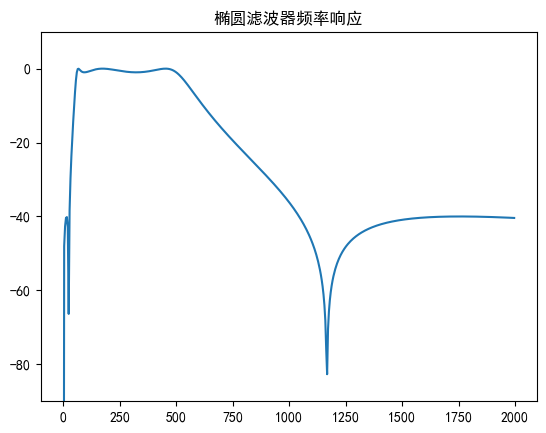

In [2]:
from utils.soundBase import *
from utils.pitch_detection import *

data, fs = soundBase('./data/C4_2_y.wav').audioread_new()
data = data - np.mean(data)
data = data / np.max(np.abs(data))
wlen = 320
inc = 80
N = len(data)
time = [i / fs for i in range(N)]
T1 = 0.05

# 4.2.1
voiceseg, vosl, SF, Ef = pitch_vad(data, wlen, inc, T1)
fn = len(SF)
frameTime = FrameTimeC(fn, wlen, inc, fs)

plt.figure(figsize=(14, 8))

plt.subplot(5, 1, 1)
plt.plot(time, data)
plt.subplot(5, 1, 2)
plt.plot(frameTime, Ef)
for i in range(vosl):
    plt.subplot(5, 1, 2)
    plt.plot(frameTime[voiceseg[i]['start']], Ef[voiceseg[i]['start']], '.k')
    plt.plot(frameTime[voiceseg[i]['end']], Ef[voiceseg[i]['start']], 'or')
    plt.legend(['能熵比', 'start', 'end'])

# 4.2.3
voiceseg, vsl, SF, Ef, period = pitch_Ceps(data, wlen, inc, T1, fs, miniL=10)
plt.subplot(5, 1, 3)
plt.plot(frameTime, period)
for i in range(vsl):
    plt.subplot(5, 1, 3)
    plt.plot(frameTime[voiceseg[i]['start']], Ef[voiceseg[i]['start']], '.k')
    plt.plot(frameTime[voiceseg[i]['end']], Ef[voiceseg[i]['start']], 'or')
    plt.legend(['倒谱法', 'start', 'end'])

# 4.2.4
voiceseg, vsl, SF, Ef, period = pitch_Corr(data, wlen, inc, T1, fs)
plt.subplot(5, 1, 4)
plt.plot(frameTime, period)
for i in range(vsl):
    plt.subplot(5, 1, 4)
    plt.plot(frameTime[voiceseg[i]['start']], Ef[voiceseg[i]['start']], '.k')
    plt.plot(frameTime[voiceseg[i]['end']], Ef[voiceseg[i]['start']], 'or')
    plt.legend(['自相关', 'start', 'end'])

# 4.2.5
p = 12
voiceseg, vsl, SF, Ef, period = pitch_Lpc(data, wlen, inc, T1, fs, p)
plt.subplot(5, 1, 5)
plt.plot(frameTime, period)
for i in range(vsl):
    plt.subplot(5, 1, 5)
    plt.plot(frameTime[voiceseg[i]['start']], Ef[voiceseg[i]['start']], '.k')
    plt.plot(frameTime[voiceseg[i]['end']], Ef[voiceseg[i]['start']], 'or')
    plt.legend(['线性预测', 'start', 'end'])

plt.savefig('images/pitch.png')
plt.close()

# 4.2.2
from scipy.signal import ellipord, ellip, freqz

fs = 8000
fs2 = fs / 2
Wp = np.array([60, 500]) / fs2
Ws = np.array([20, 1500]) / fs2
Rp = 1
Rs = 40
n, Wn = ellipord(Wp, Ws, Rp, Rs)
b, a = ellip(n, Rp, Rs, Wn, 'bandpass')
print(b)
print(a)

w, H = freqz(b, a, 1000)
H, w = H[:500], w[:500]
mag = np.abs(H)
db = 20 * np.log10((mag + 1e-20) / np.max(mag))

plt.plot(w / np.pi * fs2, db)
plt.ylim([-90, 10])
plt.title('椭圆滤波器频率响应')
plt.savefig('images/ellip.png')

![pitch](images/pitch.png)

![ellip](images/ellip.png)

## 共振峰估计

声道可以被看成一根具有非均匀截面的声管，在发音时将起共鸣器的作用。当声门处准周期脉冲激励进入声道时会引起共振特性，产生一组共振频率，这一组共振频率称为共振峰频率或简称为共振峰。共振峰参数包括共振峰频率、频带宽度和幅值，共振峰信息包含在语音频谱的包络中。因此共振峰参数提取的关键是估计语音频谱包络，并认为谱包络中的最大值就是共振峰。利用语音频谱傅里叶变换相应的低频部分进行逆变换，就可以得到语音频谱的包络曲线。依据频谱包络线各峰值能量的大小确定出第1-4共振峰.

在经典的语音信号模型中，共振峰等效为声道传输函数的复数极点对。对平均长度约为17cm声道(男性) ，在3kHz范围内大致包含三个或四个共振峰，而在5 kHz范围内包含四个或五个共振峰。高于5kHz的语音信号，能量很小。浊音信号最主要的是前三个共振峰。因此一切共振峰估计都是直接或间接地对频谱包络进行考察，关键是估计语音频谱包络，并认为谱包络中的最大值就是共振峰。

### 共振峰估计预处理
在估计之前需要进行预加重，对信号进行高频提升，还原声门的信号。
$$s'(n)=s(n)-a·s(n-1)$$

预加重有两个作用：
 - 增加一个零点：抵消声门脉冲引起的高端频谱幅度下跌，使信号频谱变得平坦且各共振峰幅度相接近;语音中只剩下声道部分的影响，所提取的特征更加符合原声道的模型。
 - 会削减低频信息，使有些基频幅值变大时，通过预加重后降低基频对共振峰检测的干扰，有利于共振峰的检测;同时减少频谱的动态范围。

另外，共振峰检测一般是分析韵母部分，所以还需要进行端点检测。可以使用基音周期检测相同的端点检测方法。

### 倒谱法共振峰估计

倒谱法共振峰估计的算法过程为：
 - 对语音信号$x(i)$进行预加重，并进行加窗，分帧，FFT处理
  $$X_i(k)=\sum_{n=1}^Nx_i(n)e^{-\frac{2\pi kn j}{N}}$$
 - 取$X_i(k)$的倒谱：
  $$\hat x_i(n)=\frac{1}{N}\sum_{k=1}^N\lg|X_i(k)|e^{-\frac{2\pi kn j}{N}}$$
 - 给倒谱信号加窗得：$h_i(n)=\hat x_i(n)\times h(n)$,这里的窗函数和倒谱的分辨率有关（和采样率和FFT长度有关）：
  $$h(n)=\left \{\begin{array}{lc}
      1&n\leqslant n_0-1 \&n\geqslant N-n_0+1\\
      0& n_0-1<n<N-n_0+1
  \end{array}\right.,n\in[0,N-1]$$
 - 求$h_i(n)$的包络线：$H_i(k)=\sum\limits_{n=1}^{N}h_i(n)e^{-\frac{2\pi kn j}{N}}$
 - 在包络线张寻找极大值，获得相应共振峰参数。

### LPC法共振峰估计
简化的语音产生模型是将辐射、声道以及声门激励的全部效应简化为一个时变的数字滤波器来等效，其传递函数为
$$H(z)=\frac{S(z)}{U(z)}=\frac{G}{1-\sum\limits_{i=1}^pa_iz_i^{-1}}$$

令$z^{-1}=\exp(-j2\pi f/f_s)$，则功率谱$P(f)$为：
$$P(f)=|H(f)|^2=\frac{G^2}{|1-\sum\limits_{i=1}^pa_i\exp(-j2\pi if/f_s)|^2}$$

利用FFT方法可对任意频率求得其功率谱幅值响应，并从幅值响应中找到共振峰，相应的求解方法有两种:抛物线内插法和线性预测系数求复数根法。

#### 抛物线内插法

在任意共振峰频率$F_i$的局部峰值频率$m\Delta f$($\Delta f$为谱图的频率间隔)，以及邻近的两个频率点$(m-1)\Delta f$,$(m+1)\Delta f$，以及他们的幅值分别为$H(m-1),H(m),H(m+1)$,可以用二次方程$a\lambda^2+b\lambda+c$来计算，求出更精确的中心频率$F_i$和带宽$B_i$。
为了方便计算，令$m\Delta f$处为零，对应于$\Delta f,0,+\Delta f$处的功率谱分别为$H(m-1),H(m),H(m+1)$,由$H=a\lambda^2+b\lambda+c$有：
$$\left \{\begin{array}{ll}
    H(m-1)=a\Delta^2-b\Delta+c\\
    H(m)=c\\
    H(m+1)=a\Delta^2+b\Delta+c
\end{array}\right.$$

假设$\Delta f=1$,则计算系数为：
$$\left \{\begin{array}{ll}
a=\frac{H(m-1)+H(m+1)}{2}-H(m)\\
b=\frac{H(m-1)+H(m+1)}{2}\\
c=H(m)
\end{array}\right.$$

极大值处中心频率为:$\lambda_{max}=-b/2a$,实际共振峰中心频率为：$F_i=\lambda_{max}\Delta f+m\Delta f$，中心频率对应的功率谱$H_p$为：
$$H_p=a\lambda_p^2+b\lambda_p+c=-\frac{b^2}{4a}+c$$

求带宽，就是在某个$\lambda$处，使得谱值为最大值的一半：
$$\frac{a\lambda^2+b\lambda+c}{H_p}=\frac{1}{2}$$

解这个二次方程可以得到：
$$\lambda _{root}=\frac{-b±\sqrt{b^2-4a(c-0.5H_p)}}{2a}$$

实际带宽可以写成：
$$B_i=2\lambda_b\Delta f$$

其中$\lambda_b=-\frac{b^2-4a(c-0.5H_p)}{2a}$。

#### 线性预测系数求根法

预测误差滤波器表示为：
$$A(z)=1-\sum_{i=1}^pa_iz^{-i}$$

其多项式复根可以精确表示共振峰的中心频率与带宽。设$z_i=r_ie^{j\theta_i}$为任意复根，其共轭值$z^*_i=r_ie^{-j\theta_i}$也是根，设$z_i$对应的共振峰频率为$F_i$，3dB带宽为$B_i$，那么有：
$$\left \{\begin{array}{ll}
    2\pi F_i/f_s=\theta_i\\e^{-B_i\pi/f_s}-r_i
\end{array} \right.$$

所以：
$$\left \{\begin{array}{ll}
    F_i=\theta_if_s/2\pi\\B_i=-\ln r_i·f_s/\pi
\end{array} \right.$$

因为预测误差滤波器阶数p是预先设定的，所以复共辄对的数量最多是p/2。因为不属于共振峰的额外极点的带宽远大于共振峰带宽，所以比较容易剔除非共振峰极点。


In [3]:
# 共振峰估计函数
import numpy as np
from utils.timefeature import *
from utils.lpc import lpc_coeff


def local_maxium(x):
    """
    求序列的极大值
    :param x:
    :return:
    """
    d = np.diff(x)
    l_d = len(d)
    maxium = []
    loc = []
    for i in range(l_d - 1):
        if d[i] > 0 and d[i + 1] <= 0:
            maxium.append(x[i + 1])
            loc.append(i + 1)
    return maxium, loc


def Formant_Cepst(u, cepstL):
    """
    倒谱法共振峰估计函数
    :param u:
    :param cepstL:
    :return:
    """
    wlen2 = len(u) // 2
    U = np.log(np.abs(np.fft.fft(u)[:wlen2]))
    Cepst = np.fft.ifft(U)
    cepst = np.zeros(wlen2, dtype=np.complex)
    cepst[:cepstL] = Cepst[:cepstL]
    cepst[-cepstL + 1:] = Cepst[-cepstL + 1:]
    spec = np.real(np.fft.fft(cepst))
    val, loc = local_maxium(spec)
    return val, loc, spec


def Formant_Interpolation(u, p, fs):
    """
    插值法估计共振峰函数
    :param u:
    :param p:
    :param fs:
    :return:
    """
    ar, _ = lpc_coeff(u, p)
    U = np.power(np.abs(np.fft.rfft(ar, 2 * 255)), -2)
    df = fs / 512
    val, loc = local_maxium(U)
    ll = len(loc)
    pp = np.zeros(ll)
    F = np.zeros(ll)
    Bw = np.zeros(ll)
    for k in range(ll):
        m = loc[k]
        m1, m2 = m - 1, m + 1
        p = val[k]
        p1, p2 = U[m1], U[m2]
        aa = (p1 + p2) / 2 - p
        bb = (p2 - p1) / 2
        cc = p
        dm = -bb / 2 / aa
        pp[k] = -bb * bb / 4 / aa + cc
        m_new = m + dm
        bf = -np.sqrt(bb * bb - 4 * aa * (cc - pp[k] / 2)) / aa
        F[k] = (m_new - 1) * df
        Bw[k] = bf * df
    return F, Bw, pp, U, loc


def Formant_Root(u, p, fs, n_frmnt):
    """
    LPC求根法的共振峰估计函数
    :param u:
    :param p:
    :param fs:
    :param n_frmnt:
    :return:
    """
    ar, _ = lpc_coeff(u, p)
    U = np.power(np.abs(np.fft.rfft(ar, 2 * 255)), -2)
    const = fs / (2 * np.pi)
    rts = np.roots(ar)
    yf = []
    Bw = []
    for i in range(len(ar) - 1):
        re = np.real(rts[i])
        im = np.imag(rts[i])
        fromn = const * np.arctan2(im, re)
        bw = -2 * const * np.log(np.abs(rts[i]))
        if fromn > 150 and bw < 700 and fromn < fs / 2:
            yf.append(fromn)
            Bw.append(bw)
    return yf[:min(len(yf), n_frmnt)], Bw[:min(len(Bw), n_frmnt)], U


In [4]:
from utils.soundBase import *
from utils.共振峰估计 import *
from scipy.signal import lfilter

plt.figure(figsize=(14, 12))

data, fs = soundBase('./data/C4_3_y.wav').audioread_new()
# 预处理-预加重
u = lfilter([1, -0.99], [1], data)

cepstL = 6
wlen = len(u)
wlen2 = wlen // 2
# 预处理-加窗
u2 = np.multiply(u, np.hamming(wlen))
# 预处理-FFT,取对数
U_abs = np.log(np.abs(np.fft.fft(u2))[:wlen2])
# 4.3.1
freq = [i * fs / wlen for i in range(wlen2)]
val, loc, spec = Formant_Cepst(u, cepstL)
plt.subplot(4, 1, 1)
plt.plot(freq, U_abs, 'k')
plt.title('频谱')
plt.subplot(4, 1, 2)
plt.plot(freq, spec, 'k')
plt.title('倒谱法共振峰估计')
for i in range(len(loc)):
    plt.subplot(4, 1, 2)
    plt.plot([freq[loc[i]], freq[loc[i]]], [np.min(spec), spec[loc[i]]], '-.k')
    plt.text(freq[loc[i]], spec[loc[i]], 'Freq={}'.format(int(freq[loc[i]])))
# 4.3.2
p = 12
freq = [i * fs / 512 for i in range(256)]
F, Bw, pp, U, loc = Formant_Interpolation(u, p, fs)

plt.subplot(4, 1, 3)
plt.plot(freq, U)
plt.title('LPC内插法的共振峰估计')

for i in range(len(Bw)):
    plt.subplot(4, 1, 3)
    plt.plot([freq[loc[i]], freq[loc[i]]], [np.min(U), U[loc[i]]], '-.k')
    plt.text(freq[loc[i]], U[loc[i]], 'Freq={:.0f}\nHp={:.2f}\nBw={:.2f}'.format(F[i], pp[i], Bw[i]))

# 4.3.3

p = 12
freq = [i * fs / 512 for i in range(256)]

n_frmnt = 4
F, Bw, U = Formant_Root(u, p, fs, n_frmnt)

plt.subplot(4, 1, 4)
plt.plot(freq, U)
plt.title('LPC求根法的共振峰估计')

for i in range(len(Bw)):
    plt.subplot(4, 1, 4)
    plt.plot([freq[loc[i]], freq[loc[i]]], [np.min(U), U[loc[i]]], '-.k')
    plt.text(freq[loc[i]], U[loc[i]], 'Freq={:.0f}\nBw={:.2f}'.format(F[i], Bw[i]))

plt.savefig('images/共振峰估计.png')
plt.close()


![共振峰估计](images/共振峰估计.png)